# Using GRASS for stream-network extraction and basins delineation

The first step towards modeling hydrological features is delineating a comprehensive hydrography network. DEMs at
different spatial resolutions allow for the identification of stream channels, using a variety of flow-routing algorithms. Such algorithms are based on the observation that water follows the steepest and shortest route along a relief, and accumulates in valleys, lowlands, flat areas and depressions. Several algorithms have been proposed for stream network routing. These algorithms proceed in several stages: determining flow directions, resolving depressions and flat areas, and finally, calculating flow accumulation. With this hydrography other stream parameters, such as stream distance, slope, etc., can be computed. Below we describe how we will extract a new high-resolution hydrography (stream-network and basins) from the 1KM DEM.

In this exercise we simulate a case that we can not run the full South America continent in one tile because we reach RAM limitation. Therefore we compute the analysis in 3 tiles and then we combine the results.

We are going to use 3 GRASS commands:  
 - [r.watershed](https://grass.osgeo.org/grass79/manuals/r.watershed.html) to derive flow accumulation  
 - [r.stream.extract](https://grass.osgeo.org/grass78/manuals/r.stream.extract.html) to extract-stream network  
 - [r.stream.basins](https://grass.osgeo.org/grass78/manuals/addons/r.stream.basins.html) to delineate basins  
 
 
**Flow direction algorithms**

In r.watershed there are 2 flow direction algorithms. 

 - SFD: single flow direction (O’Callaghan, 1984)
 - MFD: multiple flow direction (Holmgren, 1994)

Lectures: [Flow Metrics](http://spatial-ecology.net/docs/source/lectures/lect_20210518_flow_metrics.pdf)
 

**Prepare GRASS for hydrography extraction**

Considering that GRASS can not working properly under  */media/sf_LVM_shared/my_SE_data/*  therefore we create a working copy of the  *SE_data*  under  */home/user/my_SE_data/*

In [2]:
%%bash

mkdir -p /home/user/my_SE_data/exercise
cp -r /home/user/SE_data/exercise/grassdb /home/user/my_SE_data/exercise
cd /home/user/my_SE_data/exercise

# install the GRASS add-on r.stream.basins

grass76 -text grassdb/europe/PERMANENT/ <<EOF
g.extension extension=r.stream.basins
EOF

Cleaning up temporary files...
Starting GRASS GIS...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 7.6.1
GRASS GIS homepage:                      https://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Fetching <r.stream.basins> from GRASS GIS Addons repository (be patient)...
Compiling...
Installing...
Updating addons metadata file...
Installation of <r.stream.basins> successfully finished
Cleaning up temporary files...
Done.

Goodbye f

**Inputs dataset**

We are going to use the following dataset:

 - DEM at 1km resolution
 - A raster grid-cell area. Each grid-cell reports the values in km^2 
 - A raster land-sea mask labeled as 1-0 
 - A raster depression labeles as 1-0 
 - A shapefile reporting the 3 tiles

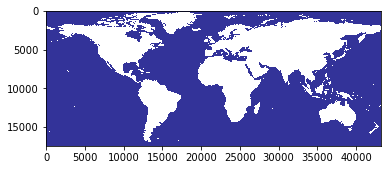

In [3]:
# sea-land mask
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/mask/msk_1km.tif")
pyplot.imshow(src.read(1), cmap='terrain', vmin=0, vmax=1)
pyplot.show()

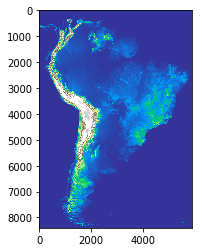

In [22]:
# digital elevation model
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/SA_elevation_mn_GMTED2010_mn_msk.tif")
pyplot.imshow(src.read(1), cmap='terrain', vmin=0, vmax=4000 )
pyplot.show()

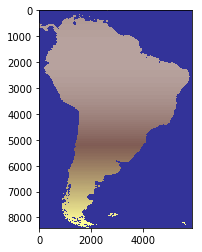

In [60]:
# area grid-cell in km^2
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/SA_are_1km_msk.tif")
pyplot.imshow(src.read(1), cmap='terrain', vmin=0, vmax=1)
pyplot.show()

   id dimension Continent  CropW  CropS  CropE  CropN  \
0   1     30x49        SA    0.6    0.0    2.0    2.0   
1   2     40x37        SA    2.8    2.8    0.0    2.8   
2   3     40x37        SA    0.3    2.8    2.8    0.0   

                                            geometry  
0  POLYGON ((-76.40000000000001 -12, -43 -12, -43...  
1  POLYGON ((-73.90000000000001 1, -34.6 1, -34.6...  
2  POLYGON ((-81.7 12.7, -41.7 12.7, -41.7 -24.5,...  


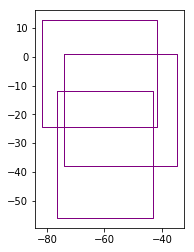

In [61]:
# tiles
import geopandas as gpd
gdf = gpd.read_file('geodata/shp/tilesComp.shp')
print (gdf)
gdf.plot(edgecolor="purple", facecolor="None")

**First run: compute MFD flow accumulation**

In [23]:
%%bash

cd /media/sf_LVM_shared/my_SE_data/exercise
grass76  -f -text --tmp-location  -c  geodata/dem/SA_elevation_mn_GMTED2010_mn_msk.tif  <<'EOF'

## import the layers
r.external input=geodata/dem/SA_elevation_mn_GMTED2010_mn_msk.tif output=elv --o # dem 
r.external input=geodata/dem/SA_all_dep_1km.tif                   output=dep --o # depression
r.external input=geodata/dem/SA_are_1km_msk.tif                   output=are --o # area-pixel
r.external input=geodata/mask/msk_1km.tif                         output=msk --o # land-ocean mask 

g.region  -m 

for tile in 1 2 3  ; do  # loop for each tile 
r.mask raster=msk --o --q # usefull to mask the flow accumulation 

wL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $2 }')
nL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $3 }')
eL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $4 }')
sL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $7 }')

g.region w=$wL  n=$nL  s=$sL  e=$eL  res=0:00:30   --o 
g.region -m

### maximum ram 66571M  for 2^63 -1   (2 147 483 647 cell)  / 1 000 000  * 31 M   
####  -m  Enable disk swap memory option: Operation is slow   
####  -b Beautify flat areas
####   threshold=1  = ~1 km2 = 0.9  m2 

echo "############# compute the flow accumulation using MFD for tile $tile ##############"
r.watershed  -b  elevation=elv  depression=dep  accumulation=flow drainage=dir_rw flow=are   memory=2000 --o --q

echo "############# extract stream ##################"
r.stream.extract elevation=elv accumulation=flow depression=dep threshold=8 direction=dir_rs stream_raster=stream  memory=2000 --o --q

echo "############# delineate basin  ##################"
r.stream.basins -l  stream_rast=stream direction=dir_rs   basins=lbasin  memory=2000 --o  --q
r.colors -r stream --q ; r.colors -r lbasin --q ; r.colors -r flow --q

echo "###### create a small zone flow binary for later use ###########"
r.mapcalc " small_zone_flow =   if( !isnull(flow) && isnull(lbasin) , 1 , null()) " --o 

echo "##### create a smaller box ########"
CropW=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropW" | awk '{  print $4 }' )
CropE=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropE" | awk '{  print $4 }' )
CropS=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropS" | awk '{  print $4 }' )
CropN=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropN" | awk '{  print $4 }' )

nS=$(g.region -m  | grep ^n= | awk -F "=" -v CropN=$CropN  '{ printf ("%.14f\n" , $2 - CropN ) }' )
sS=$(g.region -m  | grep ^s= | awk -F "=" -v CropS=$CropS  '{ printf ("%.14f\n" , $2 + CropS ) }' )
eS=$(g.region -m  | grep ^e= | awk -F "=" -v CropE=$CropE  '{ printf ("%.14f\n" , $2 - CropE ) }' )
wS=$(g.region -m  | grep ^w= | awk -F "=" -v CropW=$CropW  '{ printf ("%.14f\n" , $2 + CropW ) }' )

g.region w=$wS  n=$nS  s=$sS  e=$eS  res=0:00:30  save=smallext --o # smaller region 
g.region region=smallext --o --q
g.region  -m

echo "######## left stripe ########"
eST=$(g.region -m  | grep ^e= | awk -F "=" '{ print $2 }')
wST=$(g.region -m  | grep ^e= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS     e=$eST w=$wST  res=0:00:30 --o
r.mapcalc " lbasin_wstripe = lbasin " --o --q
g.region region=smallext --o --q 

echo "######## right stripe  ########"
wST=$(g.region -m  | grep ^w= | awk -F "=" '{ print $2   }' )
eST=$(g.region -m  | grep ^w= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS  e=$eST w=$wST  res=0:00:30 --o
r.mapcalc " lbasin_estripe    = lbasin " --o --q

g.region region=smallext --o --q 
echo "######## top stripe   ########"
nST=$(g.region -m  | grep ^n= | awk -F "=" '{ print $2   }' )
sST=$(g.region -m  | grep ^n= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region e=$eS w=$wS n=$nST s=$sST res=0:00:30  --o
r.mapcalc " lbasin_nstripe    = lbasin " --o --q
g.region region=smallext --o --q 

echo "######## bottom stripe ########"  
sST=$(g.region -m  | grep ^s= | awk -F "=" '{ print $2   }' )
nST=$(g.region -m  | grep ^s= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region   e=$eS  w=$wS  n=$nST  s=$sST  res=0:00:30 --o
r.mapcalc " lbasin_sstripe    = lbasin " --o --q
g.region region=smallext   --o --q 

echo "######## remove incompleate basins  ########"
    cat <(r.report -n -h units=c map=lbasin_estripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin_wstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin_sstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin_nstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin         | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } ' ) \
      | sort  | uniq -c | awk '{ if($1==1) {print $2"="$2 } else { print $2"=NULL"}  }' >  /tmp/lbasin_${tile}_reclass.txt 

r.reclass input=lbasin  output=lbasin_rec   rules=/tmp/lbasin_${tile}_reclass.txt   --o --q
rm -f /tmp/lbasin_${tile}_reclass.txt 

r.mapcalc  " lbasin_clean = lbasin_rec" --o --q
g.remove -f  type=raster name=lbasin_rec,lbasin_estripe,lbasin_wstripe,lbasin_nstripe,lbasin_sstripe --q

echo "############  export basin  ############"

r.mask raster=lbasin_clean --o --q
r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=lbasin_clean  output=geodata/dem/lbasinTmp_$tile.tif

echo "############ output the flow accumulation  ############"
r.mask raster=msk --o --q

r.mapcalc  " lbasin_flow_clean  = if ( !isnull(lbasin_clean ) || !isnull(small_zone_flow) , 1 , null()  ) " --o 
r.grow  input=lbasin_flow_clean  output=lbasin_flow_clean_grow  radius=4  --o 
r.mask  raster=lbasin_flow_clean_grow   --o --q 

r.out.gdal --o -f -c -m createopt="COMPRESS=DEFLATE,ZLEVEL=9"  nodata=-9999999  type=Float32 format=GTiff input=flow  output=geodata/dem/flow_${tile}.tif 

gdal_edit.py -a_ullr  $wS $nS $eS $sS  geodata/dem/flow_${tile}.tif 
gdal_edit.py -tr 0.00833333333333333333333333333333333 -0.00833333333333333333333333333333333  geodata/dem/flow_${tile}.tif 

done 

EOF


projection=3
zone=0
n=14
s=-56
w=-83
e=-34
nsres=923.44150551
ewres=703.7149865
rows=8400
cols=5880
cells=49392000
projection=3
zone=0
n=-12
s=-56
w=-76.4
e=-43
nsres=924.52244935
ewres=710.89449752
rows=5280
cols=4008
cells=21162240
############# compute the flow accumulation using MFD for tile 1 ##############
############# extract stream ##################
############# delineate basin  ##################
###### create a small zone flow binary for later use ###########
##### create a smaller box ########
projection=3
zone=0
n=-14
s=-56
w=-75.8
e=-45
nsres=924.64630106
ewres=707.62000721
rows=5040
cols=3696
cells=18627840
######## left stripe ########
######## right stripe  ########
######## top stripe   ########
######## bottom stripe ########
######## remove incompleate basins  ########
############  export basin  ############
############ output the flow accumulation  ############
projection=3
zone=0
n=1
s=-38
w=-73.9
e=-34.6
nsres=922.66504302
ewres=826.93226998
rows=4680
cols=47

Cleaning up temporary files...
Starting GRASS GIS...
Creating new GRASS GIS location <tmploc>...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 7.6.1
GRASS GIS homepage:                      https://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Reading band 1 of 1...
Link to raster map <elv> created.
Reading band 1 of 1...
Link to raster map <dep> created.
Reading band 1 of 1...
Link to raster map <are> created.
Reading band 1 of 1...
L

At this point the flow accumulation has been computed ond saved only for the entire basins.

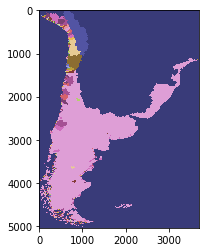

In [53]:
# flow accumualtion tile 1 
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/lbasinTmp_1.tif")
pyplot.imshow(src.read(1), cmap='tab20b' )
pyplot.show()

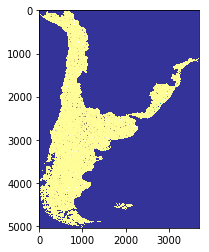

In [35]:
# flow accumualtion tile 1 
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/flow_1.tif")
pyplot.imshow(src.read(1), cmap='terrain', vmin=-4000, vmax=4000 )
pyplot.show()

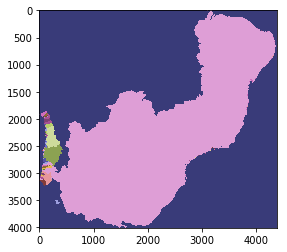

In [54]:
# flow accumualtion tile 1 
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/lbasinTmp_2.tif")
pyplot.imshow(src.read(1), cmap='tab20b' )
pyplot.show()

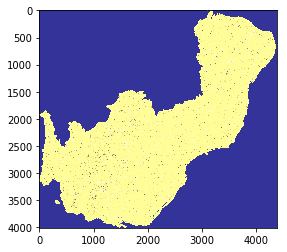

In [36]:
# flow accumualtion tile 2
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/flow_2.tif")
pyplot.imshow(src.read(1), cmap='terrain', vmin=-4000, vmax=4000 )
pyplot.show()

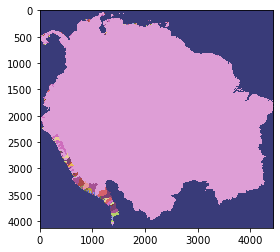

In [4]:
# flow accumualtion tile 3 
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/lbasinTmp_3.tif")
pyplot.imshow(src.read(1), cmap='tab20b' )
pyplot.show()

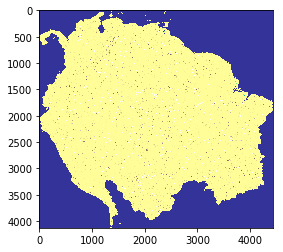

In [37]:
# flow accumualtion tile 3
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/flow_3.tif")
pyplot.imshow(src.read(1), cmap='terrain', vmin=-4000, vmax=4000 )
pyplot.show()

**Merge the flow accumulation tiles**

In [27]:
%%bash
gdalbuildvrt     -srcnodata -9999999 -vrtnodata -9999999 geodata/dem/flow_all.vrt    geodata/dem/flow_?.tif
gdal_translate   -co COMPRESS=DEFLATE -co ZLEVEL=9  geodata/dem/flow_all.vrt     geodata/dem/flow_all.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5616, 8244
0...10...20...30...40...50...60...70...80...90...100 - done.


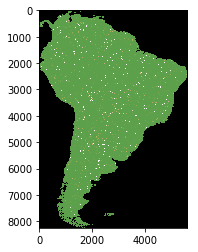

In [45]:
# flow accumualtion all South America
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/flow_all.tif")
pyplot.imshow(src.read(1), cmap='gist_earth', vmin=-4000, vmax=4000 )
pyplot.show()

**Second run: copute stream and basin using the seamless South America Flow Accumulation**

In [56]:
%%bash

grass76  -f -text --tmp-location  -c  geodata/dem/flow_all.tif   <<'EOF'

## import the layers
r.external input=geodata/dem/flow_all.tif                         output=flow --o # flow accumulation
r.external input=geodata/dem/SA_elevation_mn_GMTED2010_mn_msk.tif output=elv  --o # dem 
r.external input=geodata/dem/SA_all_dep_1km.tif                   output=dep  --o # depression
r.external input=geodata/mask/msk_1km.tif                         output=msk  --o # land-ocean mask 

g.region  -m 

for tile in 1 2 3  ; do  # loop for each tile 
r.mask raster=msk --o # usefull to mask the flow accumulation 

wL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $2 }')
nL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $3 }')
eL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $4 }')
sL=$(ogrinfo -al -where  " id  = '$tile' " geodata/shp/tilesComp.shp | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $7 }')

g.region w=$wL  n=$nL  s=$sL  e=$eL  res=0:00:30   --o 
g.region -m

### maximum ram 66571M  for 2^63 -1   (2 147 483 647 cell)  / 1 000 000  * 31 M   
####  -m  Enable disk swap memory option: Operation is slow   
####  -b Beautify flat areas
####   threshold=1  = ~1 km2 = 0.9  m2 

echo "############# extract stream ##################"
r.stream.extract elevation=elv accumulation=flow depression=dep threshold=8 direction=dir_rs stream_raster=stream  memory=2000 --o --q

echo "############# delineate basin and sub-basin  ##################"
r.stream.basins -l  stream_rast=stream direction=dir_rs   basins=lbasin  memory=2000 --o --q

r.colors -r stream --q; r.colors -r lbasin --q ; r.colors -r flow --q

echo "###### create a small zone flow binary for later use ###########"
r.mapcalc " small_zone_flow =   if( !isnull(flow) && isnull(lbasin) , 1 , null()) " --o --q

echo "##### create a smaller box ########"
CropW=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropW" | awk '{  print $4 }' )
CropE=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropE" | awk '{  print $4 }' )
CropS=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropS" | awk '{  print $4 }' )
CropN=$( ogrinfo -al   -where  " id  = '$tile' " geodata/shp/tilesComp.shp  | grep " CropN" | awk '{  print $4 }' )

nS=$(g.region -m  | grep ^n= | awk -F "=" -v CropN=$CropN  '{ printf ("%.14f\n" , $2 - CropN ) }' )
sS=$(g.region -m  | grep ^s= | awk -F "=" -v CropS=$CropS  '{ printf ("%.14f\n" , $2 + CropS ) }' )
eS=$(g.region -m  | grep ^e= | awk -F "=" -v CropE=$CropE  '{ printf ("%.14f\n" , $2 - CropE ) }' )
wS=$(g.region -m  | grep ^w= | awk -F "=" -v CropW=$CropW  '{ printf ("%.14f\n" , $2 + CropW ) }' )

g.region w=$wS  n=$nS  s=$sS  e=$eS  res=0:00:30  save=smallext --o --q # smaller region 
g.region region=smallext --o --q
g.region  -m --q

echo "######## left stripe ########"
eST=$(g.region -m  | grep ^e= | awk -F "=" '{ print $2 }')
wST=$(g.region -m  | grep ^e= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS     e=$eST w=$wST  res=0:00:30 --o --q
r.mapcalc " lbasin_wstripe = lbasin " --o --q
g.region region=smallext --o --q

echo "######## right stripe  ########"
wST=$(g.region -m  | grep ^w= | awk -F "=" '{ print $2   }' )
eST=$(g.region -m  | grep ^w= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS  e=$eST w=$wST  res=0:00:30 --o --q
r.mapcalc " lbasin_estripe    = lbasin " --o --q

g.region region=smallext --o --q
echo "######## top stripe   ########"
nST=$(g.region -m  | grep ^n= | awk -F "=" '{ print $2   }' )
sST=$(g.region -m  | grep ^n= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region e=$eS w=$wS n=$nST s=$sST res=0:00:30  --o --q
r.mapcalc " lbasin_nstripe    = lbasin " --o --q
g.region region=smallext --o --q

echo "######## bottom stripe ########"  
sST=$(g.region -m  | grep ^s= | awk -F "=" '{ print $2   }' )
nST=$(g.region -m  | grep ^s= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region   e=$eS  w=$wS  n=$nST  s=$sST  res=0:00:30 --o --q
r.mapcalc " lbasin_sstripe    = lbasin " --o --q
g.region region=smallext   --o --q

echo "######## remove incompleate basins  ########"
    cat <(r.report -n -h units=c map=lbasin_estripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin_wstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin_sstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin_nstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } '   ) \
        <(r.report -n -h units=c map=lbasin         | awk  '{ gsub ("\\|"," " ) ; { print $1 }   } ' | awk  '$1 ~ /^[0-9]+$/ { print $1 } ' ) \
      | sort  | uniq -c | awk '{ if($1==1) {print $2"="$2 } else { print $2"=NULL"}  }' >  /tmp/lbasin_${tile}_reclass.txt 

r.reclass input=lbasin  output=lbasin_rec   rules=/tmp/lbasin_${tile}_reclass.txt   --o --q
rm -f /tmp/lbasin_${tile}_reclass.txt 

r.mapcalc  " lbasin_clean = lbasin_rec" --o --q
g.remove -f  type=raster name=lbasin_rec,lbasin_estripe,lbasin_wstripe,lbasin_nstripe,lbasin_sstripe  --q

echo "############  export basin sub-basin and stream  ############"

r.mask raster=lbasin_clean --o --q
r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=lbasin  output=geodata/dem/lbasin_$tile.tif
r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=basin   output=geodata/dem/basin_$tile.tif
r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=stream  output=geodata/dem/stream_$tile.tif

done 

EOF

projection=3
zone=0
n=12.7
s=-56
w=-81.4
e=-34.6
nsres=923.4698013
ewres=706.8356204
rows=8244
cols=5616
cells=46298304
projection=3
zone=0
n=-12
s=-56
w=-76.4
e=-43
nsres=924.52244935
ewres=710.89449752
rows=5280
cols=4008
cells=21162240
############# extract stream ##################
############# delineate basin and sub-basin  ##################
###### create a small zone flow binary for later use ###########
##### create a smaller box ########
projection=3
zone=0
n=-14
s=-56
w=-75.8
e=-45
nsres=924.64630106
ewres=707.62000721
rows=5040
cols=3696
cells=18627840
######## left stripe ########
######## right stripe  ########
######## top stripe   ########
######## bottom stripe ########
######## remove incompleate basins  ########
############  export basin sub-basin and stream  ############
projection=3
zone=0
n=1
s=-38
w=-73.9
e=-34.6
nsres=922.66504302
ewres=826.93226998
rows=4680
cols=4716
cells=22070880
############# extract stream ##################
############# delineate basin 

Cleaning up temporary files...
Starting GRASS GIS...
Creating new GRASS GIS location <tmploc>...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 7.6.1
GRASS GIS homepage:                      https://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Reading band 1 of 1...
Link to raster map <flow> created.
Reading band 1 of 1...
Link to raster map <elv> created.
Reading band 1 of 1...
Link to raster map <dep> created.
Reading band 1 of 1...


**Final step: combine the tiled basins and streams**

In [57]:
%%bash

for var in lbasin stream ; do 

gdalbuildvrt  -srcnodata 0  -vrtnodata 0 geodata/dem/${var}_all.vrt    geodata/dem/${var}_?.tif
gdal_translate -co COMPRESS=DEFLATE -co ZLEVEL=9 geodata/dem/${var}_all.vrt geodata/dem/${var}_all.tif

pkstat --hist -i geodata/dem/${var}_all.tif | grep -v " 0"  >  geodata/dem/${var}_all.hist

wc=$(  wc -l geodata/dem/${var}_all.hist  | awk '{ print $1 -1 }' )

# create color table
paste -d " " <( awk '{ print $1 }' geodata/dem/${var}_all.hist )  <(echo 0; shuf -i 1-255 -n $wc -r) <(echo 0; shuf -i 1-255 -n $wc -r) <(echo 0 ; shuf -i 1-255 -n $wc -r) | awk '{ if (NR==1) {print $0 , 0 } else { print $0 , 255 }}'    >  geodata/dem/${var}_all_ct.hist
# apply color table to the stream and basins 
gdaldem color-relief -co COMPRESS=DEFLATE -co ZLEVEL=9 -co TILED=YES  -co COPY_SRC_OVERVIEWS=YES -alpha geodata/dem/${var}_all.tif geodata/dem/${var}_all_ct.hist   geodata/dem/${var}_all_ct.tif
done

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5616, 8244
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5616, 8244
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


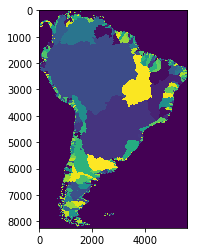

In [58]:
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/lbasin_all_ct.tif")
pyplot.imshow(src.read(1))
pyplot.show()

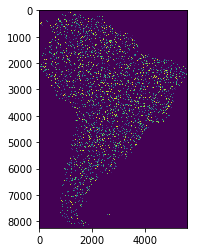

In [59]:
import rasterio
from matplotlib import pyplot
src = rasterio.open("geodata/dem/stream_all_ct.tif")
pyplot.imshow(src.read(1))
pyplot.show()